# Example 2: An Ideal, Ternary Mixture

#### This example shows the distillation column for a mixture of Benzene (heavy key), Toluene (intermediate) and Xylene (light key).

#### The graphs are different than in the ternary case.  The Rectifying and Stripping Sections are no longer linear.  The markings represent the equilibrium compositions.  
##### These sections follow a curved shape, starting closest to the pure light key component (unstable node), then traveling towards before curving away from the intermediate component (saddle node) before terminating closest to the heavy key (stable node).

##### Feasible columns exist when the Rectifying and Stripping Sections overlap, which is dependent on the Distillate and Bottoms Compositions, as well as the Reflux Ratio.

In [1]:
## IMPORT NECESSARY LIBRARIES ##
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from thermo_models.RaoultsLawModel import *
from distillation.DistillationModel import DistillationModel
from utils.AntoineEquation import * 
from IPython.display import clear_output
from distillation.DistillationTernary import *
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Button, VBox, HBox, Output
from IPython.display import clear_output
import pickle
from utils.dictionary_approx import *
from distillation.residue_curves import *

with open("./utils/pickles/ex2_fixedpoints_dict.pkl", "rb") as f:
    rtofixedpoints_dict = pickle.load(f)

#### Here, the vapor-liquid equilibrium model for the ternary system is being defined.

In [2]:
# Antoine Parameters for benzene
Ben_A = 4.72583
Ben_B = 1660.652
Ben_C = -1.461

# Antoine Parameters for toluene
Tol_A = 4.07827
Tol_B = 1343.943
Tol_C = -53.773

# Antoine Parameters for Xylene
Xyl_A = 4.14553
Xyl_B = 1474.403
Xyl_C = -55.377

P_sys = 1.0325
# Create Antoine equations for benzene and toluene
benzene_antoine = AntoineEquationBase10(Ben_A, Ben_B, Ben_C)
toluene_antoine = AntoineEquationBase10(Tol_A, Tol_B, Tol_C)
xylene_antoine = AntoineEquationBase10(Xyl_A, Xyl_B, Xyl_C)

# Create a Raoult's law object
TolBenXylSys = RaoultsLawModel(3,P_sys,["Benzene", "Toluene", "Xylene"],[benzene_antoine, toluene_antoine, xylene_antoine])

#Mass Balance Example
# Create widgets
massbal_option = widgets.Dropdown(
    options=['Feed-Distillate', 'Feed-Bottoms'],
    description='Define:',
    disabled=False
)

z1_1 = widgets.FloatText(value=0.3, description='zF1:')
z1_2 = widgets.FloatText(value=0.3, description='zF2:')

z2_1 = widgets.FloatText(value=0.6, description='zD1:')
z2_2 = widgets.FloatText(value=0.2, description='zD2:')


# Function to run when 'Submit' is clicked
def plot_mass_balance(btn):
    z_1_1, z_1_2 = z1_1.value, z1_2.value
    z_1_3 = 1 - z_1_1 - z_1_2
    z_2_1, z_2_2 = z2_1.value, z2_2.value
    z_2_3 = 1 - z_2_1 - z_2_2

    if z_1_3 < 0 or z_2_3 < 0:
        print("Invalid fractions; sum must be <= 1")
        return
    
    fig, ax = plt.subplots()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot([0, 1], [1, 0], 'k--')
    ax.set_aspect('equal')

    label1, label2 = massbal_option.value.split("-")
    alpha = (z_2_2 - z_1_2)/(z_2_1 - z_1_1)
    beta = - z_1_1 * alpha + z_1_2
    x = np.linspace(0, 1, 100)
    y = alpha * x + beta

    
    if massbal_option.value == 'Feed-Distillate':
        ax.plot([z_1_1, z_2_1], [z_1_2, z_2_2], 'ro-', label=f'{label1}-{label2}')
        for index,i in enumerate(x):
            if i > z_1_1:
                x = x[:index]
                y = y[:index]
                break
            
        ax.plot(x, y, 'r--', label = f'Bottoms Composition Space')
    else:  # Feed-Bottoms
        ax.plot([z_1_1, z_2_1], [z_1_2, z_2_2], 'bo-', label=f'{label1}-{label2}')
        for index,i in enumerate(x):
            if i > z_1_1:
                x = x[:index]
                y = y[:index]
                break
        ax.plot(x, y, 'r--', label = f'Distillate Composition Space')

    ax.text(z_1_1, z_1_2, label1, fontsize=12, ha='right')
    ax.text(z_2_1, z_2_2, label2, fontsize=12, ha='right')
    
    ax.legend()
    plt.show()

#Changing Reflux Ratio Example
reflux_ex_R_slider =  widgets.FloatLogSlider(value=1.0, base=10, min=0, max=2, step=0.001,  description='Reflux Ratio:', readout_format='.1f')
reflux_ex_go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
reflux_ex_oplines = Output()

def reflux_ex_plot_rect_strip(R = reflux_ex_R_slider):
    plt.close('all')  # Ensure that any existing figures are closed before plotting a new one.
    xF = np.array([0.3, 0.3, 0.4])
    xD = np.array([0.990, 0.0100, 1e-10])
    xB = np.array([1e-5, 0.4261,0.5749])
    distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
    fixed_points = approximate_value(rtofixedpoints_dict,R)
    fig, ax = plt.subplots(1,1,figsize= (5,5))
    distillation_model.plot_rect_strip_comp(ax)
    
    for index,point in enumerate(fixed_points['values']):
        ax.scatter(point[0], point[1], marker='x', color='black', s=100, linewidths= 10)
        if fixed_points['source_indices'][index] == 0:
            label = "Unstable"
        elif fixed_points['source_indices'][index] == 1:
            label = "saddle"
        elif fixed_points['source_indices'][index] == 2:
            label = "stable"
        else:
            label = "unexpected node: error"
        ax.text(point[0], point[1], f' {label}', verticalalignment='bottom', horizontalalignment='right')
    plt.subplots_adjust(hspace=0)
    plt.show()

def relux_ex_button(b):
    with reflux_ex_oplines:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        reflux_ex_plot_rect_strip( R=reflux_ex_R_slider.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(relux_ex_button)

reflux_ex_display = VBox([HBox([reflux_ex_R_slider, go_button]), reflux_ex_oplines])

# Generalized Mass Balance in a Ternary System for a Distillation Column

For a ternary mixture in a distillation column involving components $x_{1}$, $x_{2}$, and $x_{3}$. Let's consider $F$, $D$, and $B$ to be the molar flow rates of the feed, distillate, and bottoms, respectively.

## General Component Balance

For any component i in the system:

$$
\
Fz_{iF} = Dz_{iD} + Bz_{iB}
\
$$
Where:
- $F$: Total molar flow rate of the feed
- $D$: Total molar flow rate of the distillate
- $B$: Total molar flow rate of the bottoms
- $z_{iF}$: Mole fraction of component $i$ in the feed
- $z_{iD}$: Mole fraction of component $i$ in the distillate
- $z_{iB}$: Mole fraction of component $i$ in the bottoms

This equation can be applied individually to each component $i$ where $i = 1, 2, 3$ for the ternary case.
Combining this equation with the equation $F = D + B$,
$$
\
(D + B)z_{iF} = Dz_{iD} + Bz_{iB}
\
$$
by rearranging, we get
$$
\
\frac{D}{B} = \frac{z_{iF} - z_{iB}}{z_{iD} - z_{iF}}
\
$$
Furthermore, from an energy balance around the column excluding the condensor and the constant molar overflow assumption we get that

$$
\frac{D}{B} = \frac{z_{iF} - z_{iB}}{z_{iD} - z_{iF}} =  \frac{s + 1 - q}{r + q}                          
$$


In [3]:
massbal_button = widgets.Button(description='Submit')

# Update text fields when choice changes
def on_option_change(change):
    new_option = change['new']
    z1_1.description, z1_2.description = f'z{new_option.split("-")[0][0]}1:', f'z{new_option.split("-")[0][0]}2:'
    z2_1.description, z2_2.description = f'z{new_option.split("-")[1][0]}1:', f'z{new_option.split("-")[1][0]}2:'

massbal_option.observe(on_option_change, names='value')

# Connect the button click to the function
massbal_button.on_click(plot_mass_balance)
display(massbal_option, z1_1, z1_2, z2_1, z2_2, massbal_button)

#SHOW WHERE BOTTOMS IS EXACTLY
#Mass balance
##write down the component wise mass balance - relationship between distillate, feed, bottoms
##show them that they are collinear. If you fix these two they'll all be fixed
##Warning that not all choices of distillate composiiton for a given feed composition are possible


Dropdown(description='Define:', options=('Feed-Distillate', 'Feed-Bottoms'), value='Feed-Distillate')

FloatText(value=0.3, description='zF1:')

FloatText(value=0.3, description='zF2:')

FloatText(value=0.6, description='zD1:')

FloatText(value=0.2, description='zD2:')

Button(description='Submit', style=ButtonStyle())

# Effects of Changing Reflux Ratio on Operating Compositions

Unlike binary distillation, the operating surfaces for the rectifying and stripping sections in a ternary system reside in a 4-dimensional space. These hyperplanes are parameterized by the liquid and vapor mole fractions $x_1$, $x_2$, $y_1$, and $y_2$. Importantly, the third component's mole fraction in both phases is determinable from the first two, allowing for a reduction in dimensionality. Traditional 2D and 3D visualization tools are ill-suited for depicting these surfaces. Instead, stage-wise compositions along the column offer a more effective visualization, akin to the secondary axis in Example 1.

## Interpretation of Graphical Elements

### What Do the Blue and Red Points Signify?

These points represent the stage-wise compositions as one moves along the column. In binary systems, these correspond to the zig-zag path across the McCabe-Thiele diagram.

### Why Are There Two Curves?

Just as in binary distillation, these curves stem from different starting points: one originates from the bottoms (stripping curve) and the other from the distillate (rectifying curve). The displayed curves illustrate the column behavior if it were not interconnected.

### Criteria for a Feasible Column

Drawing a parallel to binary systems, a feasible column is one where the rectifying and stripping compositions intersect. This ensures a smooth transition in composition from the distillate to the bottoms along the column. In graphical terms, feasibility is indicated by an overlap between the rectifying and stripping curves.

#### Interactive Exploration

Move the slider to observe how the column's behavior changes. Your goal is to configure a column in which the rectifying and stripping curves overlap, signifying feasible operation. Take note of the location of fixed points—these are analogous to the intersection points between operating and equilibrium curves in binary distillation. Just like in the binary case, these fixed points define regions of infeasible compositions.

In [4]:
display(reflux_ex_display)

## Understanding the Curvature in Composition Curves

You may be wondering why the composition curves exhibit unusual curvature. To address this, it's essential to delve into the concept of residue curves. These curves provide critical insights into the system's behavior and help explain the observed curvature in the stage-wise composition graphs.

## What is a Residue Curve?

A residue curve serves as a graphical tool that outlines how a multicomponent system's composition evolves with the progressive application of heat, usually during distillation or related separation operations. This curve plays a pivotal role in understanding intricate separations, pinpointing operable regions, and flagging critical compositional landmarks like azeotropes.

In the context presented, application of heat initially causes the most volatile component (benzene, represented at the bottom right corner) to vaporize and leave the liquid phase. This makes the system lean towards an intermediate composition richer in toluene (the saddle node). Subsequent heating then drives off the toluene, leaving a liquid rich in xylene, the component with the highest boiling point. This behavior sheds light on the rectifying and stripping compositions observed earlier in the distillation column.

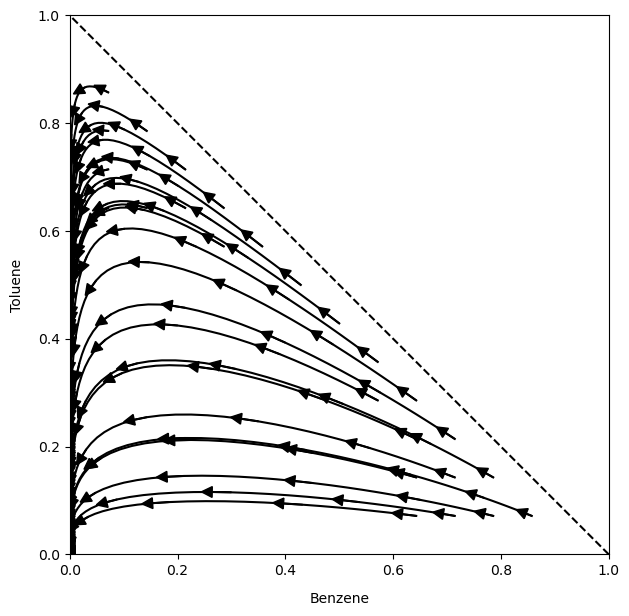

In [5]:
out_residue = Output()
rcm = residue_curve(TolBenXylSys)
fig, ax = plt.subplots(1,1,figsize= (7,7))
rcm.plot_residue_curve_int(ax,15)

## Selecting Stream Compositions: Theoretical Insights and Practical Implications

Building on our insights from mass balance equations, residue curves, and the criteria for a feasible distillation column, it becomes evident that not all stream compositions are possible or practical for operation. Particularly in multicomponent systems, where complexity is elevated, the interplay between these factors sets certain compositional constraints. These limitations restrict the range of feasible inlet and outlet streams, making it crucial to carefully select product compositions like distillate and bottoms.

So, what does this mean in practical terms? We're going to show you some examples—actual plots that lay out what works and what doesn't when you choose different product compositions. These examples will give you a hands-on look at how your choices directly affect the feasibility of your distillation column. Think of it as a visual guide to avoiding common pitfalls in design and operation.

### You can't Enrich Lowkey Component in the Distillate

This might seem obvious, but it is less intuitive here than the binary case. Despite whatever reflux ratio you choose for this selection of components, the two composition curves will never overlap

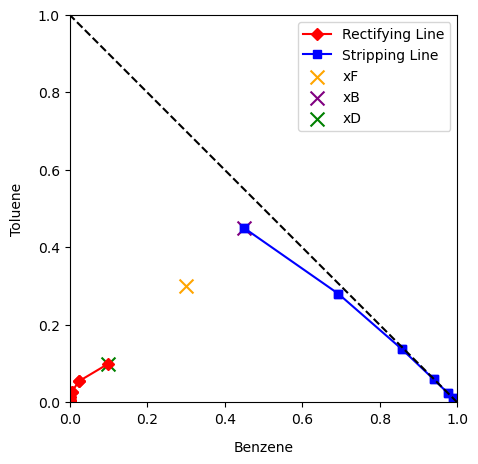

In [12]:
fig, ax = plt.subplots(1,1,figsize= (5,10)) ##CHECK MASS BALANCE
#Impossible case (dist)
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.1, 0.1, 0.8]) 
xB = np.array([0.45, 0.45,0.1])
R = 1000
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax) 

### You can't Enrich Intermediate Component in the Bottoms or Tops at High Concentration



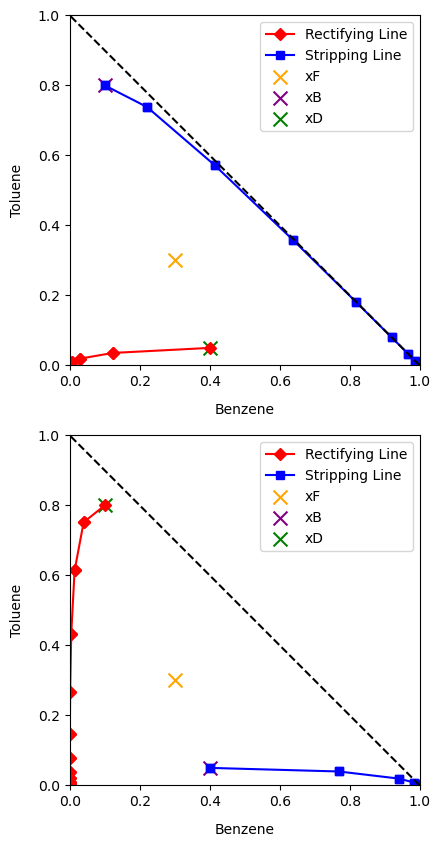

In [11]:
#Show different splits
fig, ax = plt.subplots(2,1,figsize= (5,10))

#Possible case
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.4, 0.05, 0.55])
xB = np.array([0.1,0.8,0.1])
R = 1000
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax[0])

xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.1,0.8,0.1]) 
xB = np.array([0.4, 0.05, 0.55])
R = 1000
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax[1])

### Possible Case: Enrichment of Light-key Component in Distillate and Lowkey + Intermediate Component in Bottoms 

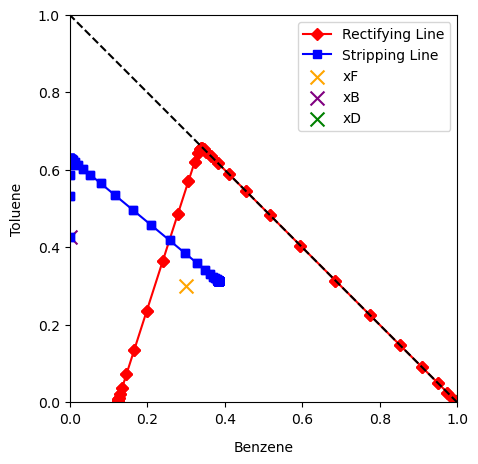

In [22]:
#Show different splits
fig, ax = plt.subplots(1,1,figsize= (5,10))
xF = np.array([0.3, 0.3, 0.4])
xD = np.array([0.990, 0.0100, 1e-10])
xB = np.array([1e-5, 0.4261,0.5749])
R = 2
distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
distillation_model.plot_rect_strip_comp(ax)



In [9]:
# xD1_slider =  widgets.FloatSlider(value=0.96, min=0.00, max=1.00, step=0.001,  description='xD Benzene:', readout_format='.2f')
# xD2_slider =  widgets.FloatSlider(value=0.03, min=0.00, max=0.04, step=0.001,  description='xD Toluene:', readout_format='.2f')
# xF1_slider =  widgets.FloatSlider(value=0.40, min=0.00, max=1.00, step=0.001,  description='xF Benzene:', readout_format='.2f')
# xF2_slider =  widgets.FloatSlider(value=0.40, min=0.00, max=0.60, step=0.001,  description='xF Toluene:', readout_format='.2f')
# go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
# out_oplines = Output()

# def update_range(change):
#     xD2_slider.max = (1 - xD1_slider.value)
#     xF2_slider.max = (1 - xF1_slider.value)

# # Attach the function to the value change event of slider1
# xD1_slider.observe(update_range, 'value')
# xF1_slider.observe(update_range, 'value')


# def plot_rect_strip_ex2(R = 2.5, VB = 1.5):
#     xB1 = (xF1_slider.value - (VB * (xD1_slider.value - xF1_slider.value) / (R+1)))
#     xB2 = (xF2_slider.value - ((xF1_slider.value - xB1) * (xF2_slider.value - xD2_slider.value) / (xF1_slider.value - xD1_slider.value)))
#     plt.close('all')  # Ensure that any existing figures are closed before plotting a new one.
#     xF = np.array([xF1_slider.value, xF2_slider.value, (1 - xF1_slider.value - xF2_slider.value)])
#     xD = np.array([xD1_slider.value, xD2_slider.value, (1 - xD1_slider.value - xD2_slider.value)])
#     xB = np.array([xB1, xB2, (1 - xB1 - xB2)])
#     distillation_model = DistillationModelTernary(TolBenXylSys, xF = xF, xD = xD, xB = xB, reflux = R)
#     fig, ax = plt.subplots(1,1,figsize= (5,5))
#     distillation_model.plot_rect_strip_comp(ax)
#     plt.subplots_adjust(hspace=0)
#     plt.show()


In [10]:
# def on_go_button_click(b):
#     with out_oplines:
#         clear_output(wait=True)
#         plt.close('all')  # Close all open matplotlib plots
#         plot_rect_strip_ex2(R=1.5)
        
# go_button = Button(description='Generate Plot')
# go_button.on_click(on_go_button_click)

# title_label = widgets.Label(value="Change composition values to see if the column is feasible. \n" 
# "A feasible column will have intersecting Rectifying and Stripping Lines.", style={'font-weight': 'bold'})

# layout = VBox([
#     title_label,
#     HBox([xD1_slider, xD2_slider]),
#     HBox([xF1_slider, xF2_slider, go_button]),
#     out_oplines
#     ])
# display(layout)